In [1]:
#Final code of the project to detect damaged tissues on the lung

In [2]:
#importing libraries as needed
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import warnings
warnings.filterwarnings('ignore')
from PIL import Image 
from PIL.ImageDraw import Draw

In [3]:
#read in csv files
csv_path = 'csv_files/'
df_image_id = pd.read_csv(csv_path + 'nih-cxr-lt_image_ids.csv')
df_label_train = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_train.csv')
df_label_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_test.csv')
df_balanced_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-test.csv')
df_balanced_val = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-val.csv')
#there are 5 files:
#all image ids
#balanced testing dataset
#balanced validation dataset
#normal testing dataset
#normal training dataset

#fixing naming convention of a columns
df_label_train.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_train.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_train.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_train.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_label_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_val.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_val.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)

#create new dataframes that contain solely heart issues
#include columns only with heart related labels
#remove rows where all values are zero (no finding == 0 -> condition)
#cant do one liner for dropping so have to use conditional drop
df_label_train_heart = df_label_train[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_train_heart = df_label_train_heart.drop(df_label_train_heart[(df_label_train_heart.Cardiomegaly == 0) & (df_label_train_heart.Infiltration == 0) & (df_label_train_heart.Mass == 0) & (df_label_train_heart.Nodule == 0) & (df_label_train_heart.Tortuous_Aorta == 0) & (df_label_train_heart.Calcification_of_the_Aorta == 0) & (df_label_train_heart.No_Finding == 0) ].index)
df_label_test_heart = df_label_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_test_heart = df_label_test_heart.drop(df_label_test_heart[(df_label_test_heart.Cardiomegaly == 0) & (df_label_test_heart.Infiltration == 0) & (df_label_test_heart.Mass == 0) & (df_label_test_heart.Nodule == 0) & (df_label_test_heart.Tortuous_Aorta == 0) & (df_label_test_heart.Calcification_of_the_Aorta == 0) & (df_label_test_heart.No_Finding == 0) ].index)
df_balanced_test_heart = df_balanced_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_test_heart = df_balanced_test_heart.drop(df_balanced_test_heart[(df_balanced_test_heart.Cardiomegaly == 0) & (df_balanced_test_heart.Infiltration == 0) & (df_balanced_test_heart.Mass == 0) & (df_balanced_test_heart.Nodule == 0) & (df_balanced_test_heart.Tortuous_Aorta == 0) & (df_balanced_test_heart.Calcification_of_the_Aorta == 0) & (df_balanced_test_heart.No_Finding == 0) ].index)
df_balanced_val_heart = df_balanced_val[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_val_heart = df_balanced_val_heart.drop(df_balanced_val_heart[(df_balanced_val_heart.Cardiomegaly == 0) & (df_balanced_val_heart.Infiltration == 0) & (df_balanced_val_heart.Mass == 0) & (df_balanced_val_heart.Nodule == 0) & (df_balanced_val_heart.Tortuous_Aorta == 0) & (df_balanced_val_heart.Calcification_of_the_Aorta == 0) & (df_balanced_val_heart.No_Finding == 0) ].index)
display(df_label_train_heart)

# #create new dataframes that contain solely lung issues (what we are currently concerned with)
# #include columns only with lung related labels
# #remove rows where all values are zero
df_label_train_lung = df_label_train[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[(df_label_train_lung.Atelectasis == 0) & (df_label_train_lung.Consolidation == 0) & (df_label_train_lung.Edema == 0) & (df_label_train_lung.Effusion == 0) & (df_label_train_lung.Emphysema == 0) & (df_label_train_lung.Fibrosis == 0) & (df_label_train_lung.Hernia == 0) & (df_label_train_lung.Infiltration == 0) & (df_label_train_lung.Mass == 0) & (df_label_train_lung.Nodule == 0) & (df_label_train_lung.Pleural_Thickening == 0) & (df_label_train_lung.Pneumonia == 0) & (df_label_train_lung.Pneumothorax == 0)& (df_label_train_lung.Pneumomediastinum == 0) & (df_label_train_lung.No_Finding == 0)].index)
df_label_test_lung = df_label_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[(df_label_test_lung.Atelectasis == 0) & (df_label_test_lung.Consolidation == 0) & (df_label_test_lung.Edema == 0) & (df_label_test_lung.Effusion == 0) & (df_label_test_lung.Emphysema == 0) & (df_label_test_lung.Fibrosis == 0) & (df_label_test_lung.Hernia == 0) & (df_label_test_lung.Infiltration == 0) & (df_label_test_lung.Mass == 0) & (df_label_test_lung.Nodule == 0) & (df_label_test_lung.Pleural_Thickening == 0) & (df_label_test_lung.Pneumonia == 0) & (df_label_test_lung.Pneumothorax == 0)& (df_label_test_lung.Pneumomediastinum == 0) & (df_label_test_lung.No_Finding == 0)].index)
df_balanced_test_lung = df_balanced_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[(df_balanced_test_lung.Atelectasis == 0) & (df_balanced_test_lung.Consolidation == 0) & (df_balanced_test_lung.Edema == 0) & (df_balanced_test_lung.Effusion == 0) & (df_balanced_test_lung.Emphysema == 0) & (df_balanced_test_lung.Fibrosis == 0) & (df_balanced_test_lung.Hernia == 0) & (df_balanced_test_lung.Infiltration == 0) & (df_balanced_test_lung.Mass == 0) & (df_balanced_test_lung.Nodule == 0) & (df_balanced_test_lung.Pleural_Thickening == 0) & (df_balanced_test_lung.Pneumonia == 0) & (df_balanced_test_lung.Pneumothorax == 0) & (df_balanced_test_lung.Pneumomediastinum == 0) & (df_balanced_test_lung.No_Finding == 0)].index)
df_balanced_val_lung = df_balanced_val[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[(df_balanced_val_lung.Atelectasis == 0) & (df_balanced_val_lung.Consolidation == 0) & (df_balanced_val_lung.Edema == 0) & (df_balanced_val_lung.Effusion == 0) & (df_balanced_val_lung.Emphysema == 0) & (df_balanced_val_lung.Fibrosis == 0) & (df_balanced_val_lung.Hernia == 0) & (df_balanced_val_lung.Infiltration == 0) & (df_balanced_val_lung.Mass == 0) & (df_balanced_val_lung.Nodule == 0) & (df_balanced_val_lung.Pleural_Thickening == 0) & (df_balanced_val_lung.Pneumonia == 0) & (df_balanced_val_lung.Pneumothorax == 0) & (df_balanced_val_lung.Pneumomediastinum == 0) & (df_balanced_val_lung.No_Finding == 0)].index)
display(df_label_train_lung)

#saving new dataframes
df_label_train_heart.to_csv(csv_path + 'label_train_heart.csv', index=False)
df_label_test_heart.to_csv(csv_path + 'label_test_heart.csv', index=False)
df_balanced_test_heart.to_csv(csv_path + 'balanced_test_heart.csv', index=False)
df_balanced_val_heart.to_csv(csv_path + 'balanced_val_heart.csv', index=False)
df_label_train_lung.to_csv(csv_path + 'label_train_lung.csv', index=False)
df_label_test_lung.to_csv(csv_path + 'label_test_lung.csv', index=False)
df_balanced_test_lung.to_csv(csv_path + 'balanced_test_lung.csv', index=False)
df_balanced_val_lung.to_csv(csv_path + 'balanced_val_lung.csv', index=False)

,id,Cardiomegaly,Infiltration,Mass,Nodule,Tortuous_Aorta,Calcification_of_the_Aorta,No_Finding,subject_id
0,00000001_000.png,1,0,0,0,0,0,0,1
1,00000002_000.png,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,1,30804


,id,Atelectasis,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumomediastinum,No_Finding,subject_id
1,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
5,00000005_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30804


In [4]:
#selecting wanted data values for predicting lung cancer (id, Mass, Nodule, No_Finding)
cancer_train = df_label_train_lung[(df_label_train_lung.Nodule == 1) | (df_label_train_lung.Mass == 1)] 
cancer_train_neg = df_label_train_lung[(df_label_train_lung.No_Finding == 1)]
cancer_val = df_balanced_val_lung[(df_balanced_val_lung.Nodule == 1) | (df_balanced_val_lung.Mass == 1)]
cancer_val_neg = df_balanced_val_lung[(df_balanced_val_lung.No_Finding == 1)]
cancer_test = df_label_test_lung[(df_label_test_lung.Nodule == 1) | (df_label_test_lung.Mass == 1)]
cancer_test_neg = df_label_test_lung[(df_label_test_lung.No_Finding == 1)]
#selecting only relevant columns 
cancer_train = cancer_train[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_train_neg = cancer_train_neg[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_val = cancer_val[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_val_neg = cancer_val_neg[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_test = cancer_test[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_test_neg = cancer_test_neg[['id', 'Mass', 'Nodule', 'No_Finding']]

In [5]:
#select range from each and append, then shuffle
train_add = cancer_train_neg[0:3701]
cancer_train = cancer_train.append(train_add)
cancer_train = cancer_train.sample(frac = 1)
val_add = cancer_val_neg[0:14]
cancer_val = cancer_val.append(val_add)
cancer_val = cancer_val.sample(frac = 1)
test_add = cancer_test_neg[0:1000]
cancer_test = cancer_test.append(test_add)
cancer_test = cancer_test.sample(frac = 1)

In [6]:
#consolidating the data and one hot encoding
conditions = [(cancer_train['No_Finding']==1),
              (cancer_train['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_train['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_train['target'])
cancer_train = cancer_train.join(encoded)
cancer_train = cancer_train.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_train.rename(columns = {cancer_train.columns[1]:'cancer_negative', cancer_train.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_train)

,id,cancer_negative,cancer_positive
290,00000176_000.png,1,0
1391,00000652_014.png,1,0
2430,00001135_000.png,1,0
2595,00001221_004.png,1,0
49059,00019805_002.png,0,1
...,...,...,...
2363,00001104_007.png,1,0
53534,00021901_000.png,0,1
1469,00000701_000.png,1,0
416,00000227_001.png,1,0


In [7]:
conditions = [(cancer_val['No_Finding']==1),
              (cancer_val['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_val['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_val['target'])
cancer_val = cancer_val.join(encoded)
cancer_val = cancer_val.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_val.rename(columns = {cancer_val.columns[1]:'cancer_negative', cancer_val.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_val)

,id,cancer_negative,cancer_positive
290,00004425_007.png,1,0
286,00004425_001.png,1,0
146,00018101_007.png,0,1
140,00015196_003.png,0,1
142,00015196_008.png,0,1
141,00015196_006.png,0,1
156,00007454_001.png,0,1
158,00007454_003.png,0,1
153,00004436_003.png,0,1
291,00013138_000.png,1,0


In [8]:
conditions = [(cancer_test['No_Finding']==1),
              (cancer_test['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_test['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_test['target'])
cancer_test = cancer_test.join(encoded)
cancer_test = cancer_test.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_test.rename(columns = {cancer_test.columns[1]:'cancer_negative', cancer_test.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_test)

,id,cancer_negative,cancer_positive
18447,00026769_000.png,0,1
12008,00016477_000.png,0,1
12818,00017243_005.png,0,1
6591,00009339_000.png,0,1
19154,00028304_005.png,0,1
...,...,...,...
48,00000090_001.png,1,0
577,00000633_001.png,1,0
1419,00001762_000.png,1,0
1034,00001223_001.png,1,0


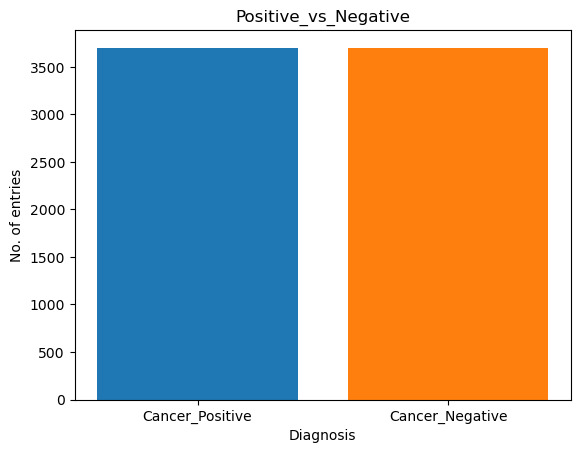

In [9]:
#plot of data
cancer_positive = len(cancer_train[cancer_train['cancer_negative'] == 0].index)
cancer_negative = len(cancer_train[cancer_train['cancer_negative'] == 1].index)
  
plt.bar('Cancer_Positive' ,cancer_positive, label= 'Positive')
plt.bar('Cancer_Negative' ,cancer_negative, label = 'Negative')
plt.xlabel("Diagnosis")
plt.ylabel("No. of entries")
plt.title("Positive_vs_Negative")
plt.show()

In [10]:
#add pathing to front of images in csv (chest_xrays/)
cancer_train['id'] = 'chest_xrays/' + cancer_train['id'].astype(str)
cancer_val['id'] = 'chest_xrays/' + cancer_val['id'].astype(str)
cancer_test['id'] = 'chest_xrays/' + cancer_test['id'].astype(str)

In [11]:
#adding entries from train to validation due to lack of entries
#adjust values
val_add = cancer_train[7000:7402]
cancer_train = cancer_train[0:7000]
cancer_val = cancer_val.append(val_add)
display(cancer_train)
display(cancer_val)

,id,cancer_negative,cancer_positive
290,chest_xrays/00000176_000.png,1,0
1391,chest_xrays/00000652_014.png,1,0
2430,chest_xrays/00001135_000.png,1,0
2595,chest_xrays/00001221_004.png,1,0
49059,chest_xrays/00019805_002.png,0,1
...,...,...,...
65563,chest_xrays/00029223_001.png,0,1
39869,chest_xrays/00015848_000.png,0,1
4277,chest_xrays/00001906_000.png,1,0
23453,chest_xrays/00009690_003.png,0,1


,id,cancer_negative,cancer_positive
290,chest_xrays/00004425_007.png,1,0
286,chest_xrays/00004425_001.png,1,0
146,chest_xrays/00018101_007.png,0,1
140,chest_xrays/00015196_003.png,0,1
142,chest_xrays/00015196_008.png,0,1
...,...,...,...
2363,chest_xrays/00001104_007.png,1,0
53534,chest_xrays/00021901_000.png,0,1
1469,chest_xrays/00000701_000.png,1,0
416,chest_xrays/00000227_001.png,1,0


In [12]:
columns = ['cancer_negative', 'cancer_positive'] 

In [13]:
#preprocessing and splitting of train and test data
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [14]:
#preprocessing of training images
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=cancer_train,
                                                   x_col="id",
                                                   y_col=columns, #can add more categories here
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=50,
                                                   subset="training")

Found 6300 validated image filenames.


In [15]:
Validation_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [16]:
#preprocessing of validation images
Validation_IMG_Set = Validation_Generator.flow_from_dataframe(dataframe=cancer_val,
                                                   x_col="id",
                                                   y_col=columns,
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=100,
                                                   subset="validation")

Found 44 validated image filenames.


In [17]:
Test_Generator = ImageDataGenerator(rescale=1./255)

In [18]:
#preprocessing of testing images
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=cancer_test,
                                                 x_col="id",
                                                 y_col=columns,
                                                 color_mode="rgb",
                                                 class_mode="raw",
                                                 batch_size=100)

Found 1969 validated image filenames.


In [19]:
# todo: clean imports
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

# misc
from tensorflow.keras.applications.resnet50 import ResNet50
import cv2
from collections import Counter
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [20]:
model = Sequential()
model.add(ResNet50(input_shape=(256, 256, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
#compiling model
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
#training the model
history = model.fit(Train_IMG_Set,
                      validation_data=Validation_IMG_Set,
                      epochs=40)

94765736/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/40
126/126 [====================

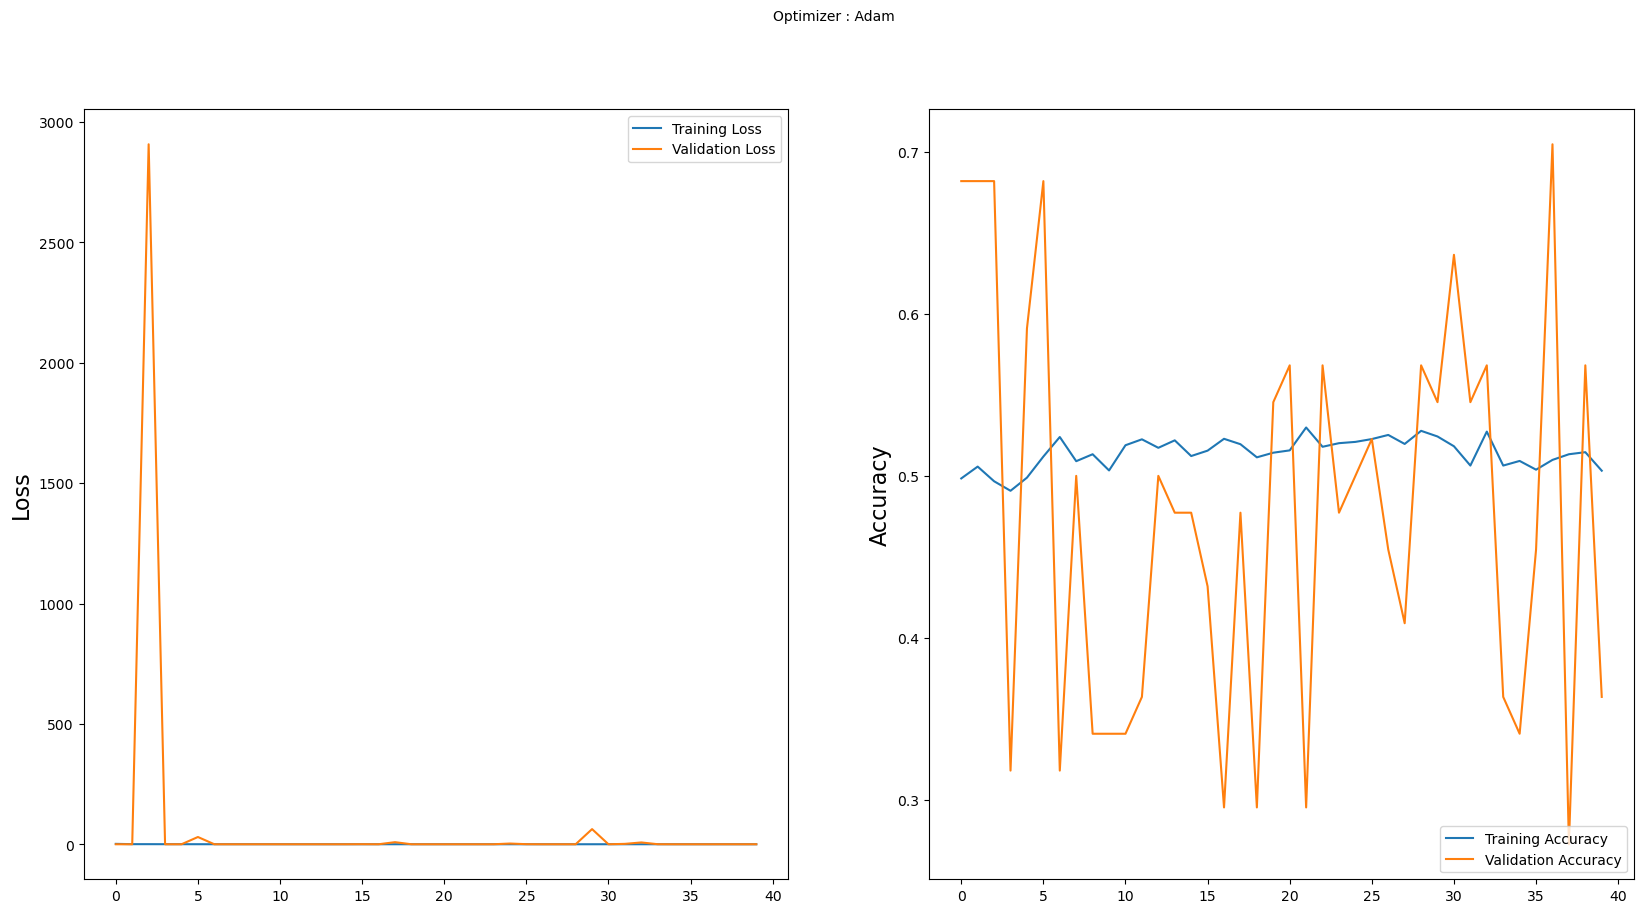

In [21]:
#plotting accuracy and loss
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [22]:
if os.path.isfile("resnet50_dispersion.h5") is False:
    model.save("resnet50_dispersion.h5")
    print("Model saved.")

Model saved.


In [23]:
#testing results
results = model.evaluate(Test_IMG_Set)
preds   = model.predict(Test_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

20/20 [==============================] - 152s 7s/step
The current model achieved a categorical accuracy of 50.74%!


In [24]:
import math
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

test_batches = Test_Generator.flow_from_dataframe(dataframe = cancer_test, x_col="id", y_col="cancer_positive", class_mode="raw", batch_size=100)

# predict the probability distribution of the data
predictions=model.predict_generator(test_batches, verbose=1)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

number_of_examples = len(Test_IMG_Set.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 100))

# 1.0 above is to skip integer division
For_Prediction_Class = []
for i in range(0,int(number_of_generator_calls)):
    For_Prediction_Class.extend(np.array(test_batches[i][1]))

print(classification_report(For_Prediction_Class,y_pred))

Found 1969 validated image filenames.
20/20 [==============================] - 151s 7s/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      1000
           1       0.00      0.00      0.00       969

    accuracy                           0.51      1969
   macro avg       0.25      0.50      0.34      1969
weighted avg       0.26      0.51      0.34      1969



In [25]:
import math
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

saved_model = load_model('resnet50_dispersion.h5')

results = saved_model.evaluate(Test_IMG_Set)
preds   = saved_model.predict(Test_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

20/20 [==============================] - 154s 7s/step
The current model achieved a categorical accuracy of 50.74%!


In [26]:
#storing test predictions
Prediction_One = model.predict(Test_IMG_Set)
Prediction_One = Prediction_One.argmax(axis=-1)
Predict_Class = model.predict_classes(Test_IMG_Set)

20/20 [==============================] - 152s 7s/step


AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
import math

In [ ]:
test_batches = Test_Generator.flow_from_dataframe(dataframe = cancer_test, x_col="id", y_col="cancer_positive", class_mode="raw", batch_size=100)
number_of_examples = len(Test_IMG_Set.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 100)) 
# 1.0 above is to skip integer division

For_Prediction_Class = []

for i in range(0,int(number_of_generator_calls)):
    For_Prediction_Class.extend(np.array(test_batches[i][1]))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

In [ ]:
#confusion matrix and other metrics
print(confusion_matrix(For_Prediction_Class,Predict_Class))
print(classification_report(For_Prediction_Class,Predict_Class))

In [ ]:
#validation
results_val = model.evaluate(Validation_IMG_Set)
preds_val   = model.predict(Validation_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results_val[1]*100,2)))

In [ ]:
#call saved model
#using an input run it on saved model
#model can predict cancerous or no cancerous
#same bounding boxes